In [2]:
import pandas as pd
import pickle
# import numpy as np # linear algebra
# # import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# import seaborn as sns
# import matplotlib.pyplot as plt
# from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from datetime import datetime
import regex as re
import pickle

In [3]:
ec10=pickle.load(open("../data/Sentiment_Market_Pharma/earnings_call_top10_ph.pickle", "rb"))
ec10=ec10.reset_index()

In [4]:
def preprocess_ec(x):
    x.replace('Operator:','')
    return x


In [5]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
import gensim
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt

In [6]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/djtom/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/djtom/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
txt=ec10.content.tolist()

In [8]:
# simplify Penn tags to n (NOUN), v (VERB), a (ADJECTIVE) or r (ADVERB)
def simplify(penn_tag):
    pre = penn_tag[0]
    if (pre == 'J'):
        return 'a'
    elif (pre == 'R'):
        return 'r'
    elif (pre == 'V'):
        return 'v'
    else:
        return 'n'

In [9]:
toks = gensim.utils.simple_preprocess(str(txt), deacc=True)
# toks


In [10]:
nltk.download('stopwords')
nltk.download('omw-1.4')

def preprocess(text):
    stop_words = stopwords.words('english')
    toks = gensim.utils.simple_preprocess(str(text), deacc=True)
    wn = WordNetLemmatizer()
    # return [wn.lemmatize(tok, simplify(pos)) for tok, pos in nltk.pos_tag(toks) if tok not in stop_words]
    return [tok for tok in toks if tok not in stop_words]

[nltk_data] Downloading package stopwords to /home/djtom/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/djtom/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [11]:
corp = [preprocess(line) for line in txt]
# corp

In [12]:
dictionary = gensim.corpora.Dictionary(corp)
len(dictionary)

29068

In [13]:
def viz_model(model, modeldict):
    ntopics = model.num_topics
    # top words associated with the resulting topics
    topics = ['Topic : '.format(t,modeldict[w]) 
              for t in range(ntopics) 
              for w,p in model.get_topic_terms(t, topn=1)]
              
    terms = [modeldict[w] for w in modeldict.keys()]
    fig,ax=plt.subplots()
    ax.imshow(model.get_topics())  # plot the numpy matrix
    ax.set_xticks(modeldict.keys())  # set up the x-axis
    ax.set_xticklabels(terms, rotation=90)
    ax.set_yticks(np.arange(ntopics))  # set up the y-axis
    ax.set_yticklabels(topics)
    plt.show()

In [14]:
def test_eta(eta, dictionary, ntopics, print_topics=True, print_dist=True):
    np.random.seed(42) # set the random seed for repeatability
    bow = [dictionary.doc2bow(line) for line in corp] # get the bow-format lines with the set dictionary
    with (np.errstate(divide='ignore')):  # ignore divide-by-zero warnings
        model = gensim.models.ldamodel.LdaModel(
            corpus=bow, id2word=dictionary, num_topics=ntopics,
            random_state=42, chunksize=100, eta=eta,
            eval_every=-1, update_every=1,
            passes=150, alpha='auto', per_word_topics=True)
    # visualize the model term topics
    viz_model(model, dictionary)
    print('Perplexity: :.2f'.format(model.log_perplexity(bow)))
    if print_topics:
        # display the top terms for each topic
        for topic in range(ntopics):
            print('Topic : '.format(topic, [dictionary[w] for w,p in model.get_topic_terms(topic, topn=3)]))
    if print_dist:
        # display the topic probabilities for each document
        for line,bag in zip(txt,bow):
            doc_topics = ['(, :.1%)'.format(topic, prob) for topic,prob in model.get_document_topics(bag)]
            print(' '.format(line, doc_topics))
    return model

In [15]:
#this cell creates a very low prior for all terms not in the dictionary (priors) and a very high prior for terms found
#in the dictionary
#watch out that you need to pass a dictionary that is pre-processed the same way you are pre-processing the text

def create_eta(priors, etadict, ntopics):
    eta = np.full(shape=(ntopics, len(etadict)), fill_value=0.0001) # create a (ntopics, nterms) matrix and fill with low number
    for word, topic in priors.items(): # for each word in the list of priors
        keyindex = [index for index,term in etadict.items() if term==word] # look up the word in the dictionary
        if (len(keyindex)>0): # if it's in the dictionary
            eta[topic,keyindex[0]] = 500  # put a large number in there
    return eta

In [16]:
# test_eta('auto', dictionary, ntopics=6)

In [17]:
#emulating the sp500 quant report on ideal topics and bidirectional tags to extract from earnings calls
t1_revenue=['sales', 'revenue', 'top line', 'top bottom line', 'net revenue', 'organic revenue growth', 'organic sales growth', 'operational sales']
t2_earnings=['eps', 'earnings', 'earnings per share',
'net income', 'bottom line', 'top bottom line']
t3_profitability=['margin', 'gross margin', 'operating margin', 'return invested capital', 'return capital']
t4_operatingincome=['ebit', 'operating income', 'operating profit', 'operating earning']
t5_cashflow=['cash flow', 'operating cash flow', 'cash flow operations',
'free cash flow']
t6_shareholderreturn=['buyback', 'dividends', 'dividend per share', 'share repurchase', 'repurchased million shares']

In [18]:
uniontopics=t1_revenue+t2_earnings+t3_profitability+t4_operatingincome+t5_cashflow+t6_shareholderreturn

In [19]:
for word in uniontopics[0:3]:
    mask=ec10.content.str.contains(word)
    result=ec10[mask].content
    print(f"{word} exists in the following rows:\n{result.count()}\n")

sales exists in the following rows:
514

revenue exists in the following rows:
456

top line exists in the following rows:
320



Okay so a casual investigation of the data reveals that there are sufficient mentions of these terms within the earnings calls to justify a topic modeling based on this approach. Let's give this a try!

In [20]:
#struggling with getting trigrams into topic modeling topics
#should I get the lists into the 
alltopic_format=[]
for word in uniontopics:
    alltopic_format.append('_'.join(word.split(' ')))

In [21]:
t1_revenue_f=[]
t2_earnings_f=[]
t3_profitability_f=[]
t4_operatingincome_f=[]
t5_cashflow_f=[]
t6_shareholderreturn_f=[]


In [22]:
for word in t1_revenue:
    t1_revenue_f.append('_'.join(word.split(' ')))
for word in t2_earnings:
    t2_earnings_f.append('_'.join(word.split(' ')))
for word in t3_profitability:
    t3_profitability_f.append('_'.join(word.split(' ')))
for word in t4_operatingincome:
    t4_operatingincome_f.append('_'.join(word.split(' ')))
for word in t5_cashflow:
    t5_cashflow_f.append('_'.join(word.split(' ')))
for word in t6_shareholderreturn:
    t6_shareholderreturn_f.append('_'.join(word.split(' ')))

In [23]:
trigram_bigram_root=[]
for word in ['_'.join(x.split('_')[0:2]) for x in alltopic_format if x.count('_') > 1 ]:
    trigram_bigram_root.append(word)
    

In [24]:
bigrams_pure=[]
for word in ['_'.join(x.split('_')[0:2]) for x in alltopic_format if x.count('_') == 1 ]:
    bigrams_pure.append(word)
    

In [25]:
unigrams_pure=[]
for word in [x for x in alltopic_format if x.count('_') <1 ]:
    unigrams_pure.append(word)
unigrams_pure=list(set(unigrams_pure))

In [26]:
bigram = gensim.models.Phrases(corp, min_count=1, threshold=5) # higher threshold fewer phrases.

In [27]:
frozen_bigram = bigram.freeze()  # freeze bigrams' scores for compactness/efficiency
for bigramword in trigram_bigram_root:
    frozen_bigram.phrasegrams[bigramword] = float('inf')
for unigramword in unigrams_pure:
    frozen_bigram.phrasegrams[unigramword] = float('inf')
for bigramword in bigrams_pure:
    frozen_bigram.phrasegrams[bigramword] = float('inf')

In [28]:
trigram = gensim.models.Phrases(frozen_bigram[corp], threshold=1) 
trifreeze=trigram.freeze()
for word in alltopic_format:
    trifreeze.phrasegrams[word]=float('Inf')


# trigram_mod = gensim.models.phrases.Phraser(trifreeze)
words_trigram = [trifreeze[doc] for doc in corp]
dictionarytrigram = gensim.corpora.Dictionary(words_trigram)
len(dictionarytrigram)
#55949

56126

In [29]:
apriori_original = dict()
for a in t1_revenue_f:
    apriori_original[a]=0

for b in t2_earnings_f:

    apriori_original[b]=1

for c in t3_profitability_f:
    
    apriori_original[c]=2

for d in t4_operatingincome_f:

    apriori_original[d]=3
for e in t5_cashflow_f:

    apriori_original[e]=4

for f in t6_shareholderreturn_f:
    apriori_original[f]=5

# for b in 

# t1_revenue_f=[]
# t2_earnings_f=[]
# t3_profitability_f=[]
# t4_operatingincome_f=[]
# t5_cashflow_f=[]
# t6_shareholderreturn_f=[]
#generate the eta vector
# eta = create_eta(apriori_original, dictionary, 10)

In [30]:
apriori_original

{'sales': 0,
 'revenue': 0,
 'top_line': 0,
 'top_bottom_line': 1,
 'net_revenue': 0,
 'organic_revenue_growth': 0,
 'organic_sales_growth': 0,
 'operational_sales': 0,
 'eps': 1,
 'earnings': 1,
 'earnings_per_share': 1,
 'net_income': 1,
 'bottom_line': 1,
 'margin': 2,
 'gross_margin': 2,
 'operating_margin': 2,
 'return_invested_capital': 2,
 'return_capital': 2,
 'ebit': 3,
 'operating_income': 3,
 'operating_profit': 3,
 'operating_earning': 3,
 'cash_flow': 4,
 'operating_cash_flow': 4,
 'cash_flow_operations': 4,
 'free_cash_flow': 4,
 'buyback': 5,
 'dividends': 5,
 'dividend_per_share': 5,
 'share_repurchase': 5,
 'repurchased_million_shares': 5}

In [31]:
# trigram = gensim.models.Phrases(frozen_phrases[corp], threshold=10) 

In [32]:
# trifreeze=trigram.freeze()
# trifreeze.phrasegrams['top_bottom_line']=float('Inf')
# trifreeze.phrasegrams['organic_revenue_growth']=float('Inf')
# trifreeze.phrasegrams['organic_sales_growth']=float('Inf')
# trifreeze.phrasegrams['earnings_per_share']=float('Inf')
# trifreeze.phrasegrams['return_invested_capital']=float('Inf')


In [33]:
# trigram_mod = gensim.models.phrases.Phraser(trifreeze)
# words_trigram = [trifreeze[doc] for doc in corp]

In [41]:
eta = create_eta(apriori_original, dictionarytrigram,6)

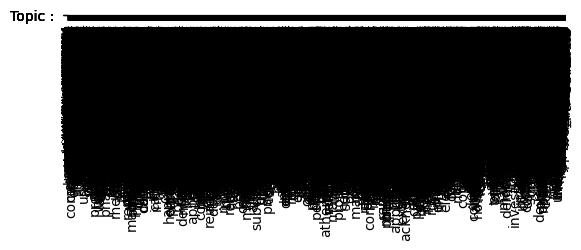

Perplexity: :.2f
Topic : 
Topic : 
Topic : 
Topic : 
Topic : 
Topic : 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 

In [42]:
ldamodel_1=test_eta(eta, dictionarytrigram, ntopics=6)

In [43]:
ldamodel_1.print_topics(num_topics=6, num_words=15)

[(0,
  '0.016*"quarter" + 0.015*"sales" + 0.014*"growth" + 0.011*"year" + 0.010*"business" + 0.007*"market" + 0.007*"million" + 0.007*"think" + 0.006*"us" + 0.006*"impact" + 0.005*"basis" + 0.005*"first" + 0.005*"products" + 0.005*"well" + 0.005*"would"'),
 (1,
  '0.012*"quarter" + 0.012*"year" + 0.008*"question" + 0.007*"business" + 0.006*"million" + 0.006*"first" + 0.006*"eps" + 0.005*"products" + 0.005*"revenue" + 0.005*"earnings" + 0.005*"operator" + 0.005*"billion" + 0.005*"next" + 0.005*"call" + 0.005*"would"'),
 (2,
  '0.012*"think" + 0.010*"data" + 0.009*"patients" + 0.008*"year" + 0.008*"question" + 0.008*"thanks" + 0.007*"quarter" + 0.006*"market" + 0.006*"would" + 0.006*"look" + 0.006*"next" + 0.006*"first" + 0.006*"growth" + 0.006*"strong" + 0.005*"thank"'),
 (3,
  '0.012*"growth" + 0.009*"insulin" + 0.008*"also" + 0.008*"sales" + 0.008*"market" + 0.008*"thank" + 0.007*"glp" + 0.007*"please" + 0.006*"lars" + 0.006*"first" + 0.006*"albert" + 0.005*"diabetes" + 0.005*"next" +

In [44]:
# import pickle

# filehandler = open("../data/ldamodel.pkl","wb")
# pickle.dump(ldamodel_1,filehandler)
# filehandler.close()


In [34]:

filehandler=open("../data/ldamodel.pkl","rb")
ldamodel_1=pickle.load(filehandler)
filehandler.close()

In [35]:
topicallocation=[]
for doc in words_trigram:
    topicallocation.append(ldamodel_1.get_document_topics(bow=dictionarytrigram.doc2bow(doc)))

In [36]:
for i,t in enumerate(topicallocation):
    for topic, prob in t:
        topic='topic'+str(topic)
        ec10.loc[ec10.index[i],topic]=prob

In [44]:
ec10=ec10.fillna(0)

In [38]:
ldamodel_1.get_document_topics(bow=dictionarytrigram.doc2bow(words_trigram[10]))

[(0, 0.18634164),
 (1, 0.59082854),
 (2, 0.013403422),
 (4, 0.056326713),
 (5, 0.15304606)]

In [39]:
# test_eta('auto', dictionarytrigram, ntopics=6)

In [40]:
#dictionary based topic modeling
positive_words=[ 'increase', 'increased', 'increases', 'increasing', 'increasingly', 'expand', 'expanded', 'expanding', 'expands', 'expansion', 'expansions', 'grow', 'grows', 'grew', 'growth', 'growths', 'improve', 'improved', 'improves', 'improvement', 'improvements', 'strong', 'stronger', 'strongest', 'strongly' ]
negative_words=['decline', 'declined', 'declines', 'declining', 'deteriorate', 'deteriorates', 'deteriorated', 'deteriorating', 'compress', 'compressed', 'compresses', 'compressing', 'compressible', 'compression', 'reduce', 'reduces', 'reduced', 'reducing', 'reduction', 'reductions', 'weak', 'weaker', 'weakest', 'weaken', 'weakens', 'weakened', 'weakening', 'weakness', 'weaknesses']
guidance_words=['full year outlook', 'full year expect', 'guidance', 'outlook', 'forecast', 'expect', 'expects', 'expected', 'expecting', 'expectation', 'expectations']

In [41]:
t1_revenue_f
t2_earnings_f
t3_profitability_f
t4_operatingincome_f
t5_cashflow_f
t6_shareholderreturn_f


['buyback',
 'dividends',
 'dividend_per_share',
 'share_repurchase',
 'repurchased_million_shares']

In [42]:
ec10.date.max()

'2022-02-10'

In [45]:
#cosine similarity based on the topic modeling
from sklearn.metrics.pairwise import cosine_similarity
ec10

,index,symbol,quarter,year,date,content,topic0,topic1,topic2,topic4,topic5,topic3
0,0,PFE,4,2007,2008-01-24,"Operator: Amal Naj, Head of Development. Pleas...",0.145448,0.650248,0.050793,0.029116,0.117531,0.0
1,0,PFE,3,2007,2007-10-18,"Operator: Mr. Amal Naj, Senior VicePresident o...",0.181578,0.577258,0.000000,0.032369,0.208566,0.0
2,0,PFE,2,2007,2007-07-18,"Operator: Amal Naj, Head of Investor Relations...",0.207389,0.452576,0.040011,0.049867,0.250117,0.0
3,0,PFE,4,2008,2009-01-28,Operator: Good morning ladies and gentlemen an...,0.254029,0.534936,0.020019,0.094598,0.096381,0.0
4,0,PFE,1,2008,2008-04-17,"Operator: Now we have Amal Naj, Head of Invest...",0.187469,0.584967,0.019077,0.062089,0.146357,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
510,0,MRK,4,2020,2021-02-04,"Operator: Good morning. My name is Lara, and I...",0.012468,0.000000,0.000000,0.832527,0.151437,0.0
511,0,MRK,1,2021,2021-04-29,"Operator: Good morning. My name is Lara, and I...",0.024340,0.000000,0.028424,0.867022,0.071462,0.0
512,0,MRK,2,2021,2021-07-29,Operator: Good morning. My name is Mary Serran...,0.000000,0.000000,0.018550,0.913855,0.062357,0.0
513,0,MRK,3,2021,2021-10-28,Operator: Good morning. My name is Grace Lakra...,0.019633,0.000000,0.017802,0.826665,0.135777,0.0


In [51]:
t1_revenue

['sales',
 'revenue',
 'top line',
 'top bottom line',
 'net revenue',
 'organic revenue growth',
 'organic sales growth',
 'operational sales']

In [55]:
nltk.sent_tokenize(ec10['content'].iloc[0])

['Operator: Amal Naj, Head of Development.',
 'Please begin the call.',
 'Amal Naj: Head of Investor Development.',
 'Good afternoon and thank you for joining us on this call to review our fourth quarter 2007 performance.',
 "I am here with Jeff Kindler, Chairman and CEO; Frank D'Amelio, Chief Financial Officer, and other members of our senior management.",
 'The financial chart that will be presented on this call can be viewed on our homepage at www.pfizer.com in the Investor Presentations tab by clicking on the link Quarterly Corporate Performance - Fourth Quarter 2007.',
 "We will end our conference call at 1 o'clock sharp, and as we would like you to... as we would like to hear from as many as you and in this time we would appreciate if you would limit yourself to just one part question.",
 'Time permitting we will come back to you for any follow-ups.',
 'Before we start, I would like to remind you that our discussions during this conference call will include forward-looking statem

In [90]:
def topiccount(doc):
    c1,c2,c3,c4,c5,c6,i=0,0,0,0,0,0,0

    for sent in nltk.sent_tokenize(doc):
        if any(word in sent for word in t1_revenue):
            c1+=1
        if any(word in sent for word in t2_earnings):
            c2+=1
        if any(word in sent for word in t3_profitability):
            c3+=1
        if any(word in sent for word in t4_operatingincome):
            c4+=1
        if any(word in sent for word in t5_cashflow):
            c5+=1
        if any(word in sent for word in t6_shareholderreturn):
            c6+=1
        i+=1
    return c1/i,c2/i,c3/i,c4/i,c5/i,c6/i


In [99]:
def directionalitycount(doc):
    c1,c2,c3,c4,c5,c6,i=0,0,0,0,0,0,0

    for sent in nltk.sent_tokenize(doc):
        if any(word in sent for word in t1_revenue) and any(word in sent for word in positive_words) and any(word in sent for word in guidance_words):
            c1+=1
        if any(word in sent for word in t1_revenue) and any(word in sent for word in negative_words) and any(word in sent for word in guidance_words):
            c1-=1
        if any(word in sent for word in t2_earnings) and any(word in sent for word in positive_words) and any(word in sent for word in guidance_words):
            c2+=1
        if any(word in sent for word in t2_earnings) and any(word in sent for word in negative_words) and any(word in sent for word in guidance_words):
            c2-=1
        if any(word in sent for word in t3_profitability) and any(word in sent for word in positive_words) and any(word in sent for word in guidance_words):
            c3+=1
        if any(word in sent for word in t3_profitability) and any(word in sent for word in negative_words) and any(word in sent for word in guidance_words):
            c3-=1
        if any(word in sent for word in t4_operatingincome) and any(word in sent for word in positive_words) and any(word in sent for word in guidance_words):
            c4+=1
        if any(word in sent for word in t4_operatingincome) and any(word in sent for word in negative_words) and any(word in sent for word in guidance_words):
            c4-=1
        if any(word in sent for word in t5_cashflow) and any(word in sent for word in positive_words) and any(word in sent for word in guidance_words):
            c5+=1
        if any(word in sent for word in t5_cashflow) and any(word in sent for word in negative_words) and any(word in sent for word in guidance_words):
            c5-=1
        if any(word in sent for word in t6_shareholderreturn) and any(word in sent for word in positive_words) and any(word in sent for word in guidance_words):
            c6+=1
        if any(word in sent for word in t6_shareholderreturn) and any(word in sent for word in negative_words) and any(word in sent for word in guidance_words):
            c6-=1
        i+=1
    return c1/i,c2/i,c3/i,c4/i,c5/i,c6/i


In [100]:
def guidancecount(doc):
    c1,c2,c3,c4,c5,c6,i=0,0,0,0,0,0,0

    for sent in nltk.sent_tokenize(doc):
        if any(word in sent for word in t1_revenue) and any(word in sent for word in positive_words):
            c1+=1
        if any(word in sent for word in t1_revenue) and any(word in sent for word in negative_words):
            c1-=1
        if any(word in sent for word in t2_earnings) and any(word in sent for word in positive_words):
            c2+=1
        if any(word in sent for word in t2_earnings) and any(word in sent for word in negative_words):
            c2-=1
        if any(word in sent for word in t3_profitability) and any(word in sent for word in positive_words):
            c3+=1
        if any(word in sent for word in t3_profitability) and any(word in sent for word in negative_words):
            c3-=1
        if any(word in sent for word in t4_operatingincome) and any(word in sent for word in positive_words):
            c4+=1
        if any(word in sent for word in t4_operatingincome) and any(word in sent for word in negative_words):
            c4-=1
        if any(word in sent for word in t5_cashflow) and any(word in sent for word in positive_words):
            c5+=1
        if any(word in sent for word in t5_cashflow) and any(word in sent for word in negative_words):
            c5-=1
        if any(word in sent for word in t6_shareholderreturn) and any(word in sent for word in positive_words):
            c6+=1
        if any(word in sent for word in t6_shareholderreturn) and any(word in sent for word in negative_words):
            c6-=1
        i+=1
    return c1/i,c2/i,c3/i,c4/i,c5/i,c6/i


In [91]:
topicdictcount=ec10.copy()

In [93]:
topicdictcount['result']=topicdictcount.content.apply(topiccount)
topicdictcount[['t1','t2','t3','t4','t5','t6']]=topicdictcount['result'].to_list()

In [101]:
topicdictcount[['t1d','t2d','t3d','t4d','t5d','t6d']]=topicdictcount.content.apply(directionalitycount).to_list()

In [103]:
topicdictcount[['t1dg','t2dg','t3dg','t4dg','t5dg','t6dg']]=topicdictcount.content.apply(guidancecount).to_list()

In [104]:
topicdictcount

,index,symbol,quarter,year,date,content,topic0,topic1,topic2,topic4,...,t3d,t4d,t5d,t6d,t1dg,t2dg,t3dg,t4dg,t5dg,t6dg
0,0,PFE,4,2007,2008-01-24,"Operator: Amal Naj, Head of Development. Pleas...",0.145448,0.650248,0.050793,0.029116,...,0.000000,0.0,0.001792,0.0,0.019713,0.000000,0.001792,0.0,0.001792,0.000000
1,0,PFE,3,2007,2007-10-18,"Operator: Mr. Amal Naj, Senior VicePresident o...",0.181578,0.577258,0.000000,0.032369,...,0.000000,0.0,0.000000,0.0,-0.002041,-0.006122,0.000000,0.0,0.000000,0.002041
2,0,PFE,2,2007,2007-07-18,"Operator: Amal Naj, Head of Investor Relations...",0.207389,0.452576,0.040011,0.049867,...,0.000000,0.0,0.000000,0.0,-0.007317,0.002439,0.000000,0.0,0.000000,0.000000
3,0,PFE,4,2008,2009-01-28,Operator: Good morning ladies and gentlemen an...,0.254029,0.534936,0.020019,0.094598,...,0.000000,0.0,0.002747,0.0,0.024725,0.010989,0.000000,0.0,0.005495,0.000000
4,0,PFE,1,2008,2008-04-17,"Operator: Now we have Amal Naj, Head of Invest...",0.187469,0.584967,0.019077,0.062089,...,0.000000,0.0,0.000000,0.0,0.024048,0.004008,0.004008,0.0,0.002004,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510,0,MRK,4,2020,2021-02-04,"Operator: Good morning. My name is Lara, and I...",0.012468,0.000000,0.000000,0.832527,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.006316,0.0,0.002105,0.000000
511,0,MRK,1,2021,2021-04-29,"Operator: Good morning. My name is Lara, and I...",0.024340,0.000000,0.028424,0.867022,...,0.005698,0.0,0.000000,0.0,0.017094,0.005698,0.008547,0.0,0.000000,0.000000
512,0,MRK,2,2021,2021-07-29,Operator: Good morning. My name is Mary Serran...,0.000000,0.000000,0.018550,0.913855,...,0.012474,0.0,0.000000,0.0,0.022869,-0.002079,0.020790,0.0,0.000000,0.000000
513,0,MRK,3,2021,2021-10-28,Operator: Good morning. My name is Grace Lakra...,0.019633,0.000000,0.017802,0.826665,...,0.000000,0.0,0.000000,0.0,0.025048,0.001927,0.003854,0.0,0.000000,0.000000
